In [1]:
import spacy
import pickle
from spacy import displacy
nlp = spacy.load('en_core_web_trf')
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm as tqdm_notebook
import collections
import re
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [2]:
colors = list(mcolors.CSS4_COLORS.keys())

### Get Plant Glossary List

In [3]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_plant_morphology'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   

glossary = collections.defaultdict(list)
# Find all H4 
for chapter in soup.find_all('h4')[0:]:
    # Clean
    chapter_text = chapter.text.rstrip('[edit]')
    # Find all siblings
    for sibling in chapter.find_next_siblings():
        # Find the parent
        for parent in sibling.find_previous_sibling('h4'):
            # Only append if correspond to current chapter
            if parent.text == chapter_text:
                if 'â' in sibling.text:
                    for tag in sibling.find_all('li'):
                        candidates = tag.text.split('â')[0]
                        candidates = candidates.split('/')
                        for candidate in candidates:
                            glossary[chapter_text.lower()].append(candidate.strip().lower())

In [4]:
glossary.keys()

dict_keys(['morphology', 'roots', 'stems', 'buds', 'leaves', 'basic flower parts', 'inflorescences', 'insertion of floral parts', 'union of flower parts', 'flower sexuality and presence of floral parts', 'flower symmetry', 'terms for fruits', 'fruit types', 'pteridophytes', 'bryophytes'])

In [5]:
glossary['leaves'] += [
    'glume',
    'surface',
    'margin'
]
glossary['basic flower parts'] +=[
    'floret'
]
glossary['inflorescences'] += [
    'spikelets',
    'lemma',
    'racemes',
    'axis'
]
glossary['leaves'] += [
    'rhachilla'
]

### Load the data

In [6]:
data = pickle.load(open('../data/description/04_TRAIN_0000000-0014557_PLANTS.pkl', 'rb'))

### Define Functions

### Extract data

In [267]:
descriptions = collections.defaultdict(list)
descriptions_text = collections.defaultdict(list)

### PLOTTING ###
parts = []
### PLOTTING ###

compounds = [
    'upper', 'lower',
    'dorsal', 'central',
]

for species in tqdm_notebook(list(data.keys())[0:1]):
    for idx, text in enumerate(data[species][12:13]):
        doc = nlp(text.lower().capitalize())
        
        for token in doc:            
            # Skip compounds
            if token.dep_ == 'compound':
                continue
            # Only (proper) NOUNS
            if token.pos_ not in ['NOUN', 'PROPN']:
                continue
            #else:
            #    print(token.lemma_.lower())
            #    print(token.lemma_.lower() in glossary['inflorescences'])
            for headlist, sublist in glossary.items():

                if token.lemma_.lower() in sublist or token.text.lower() in sublist:
                    
                    descriptions[species].append(('species', 'base part', headlist))
                    
                    ### RECONSTRUCT COMPOUNDS ###
                    if token.i == 0:
                        trait = token
                    elif doc[token.i - 3].dep_ == 'compound':
                        trait = doc[token.i - 3: token.i + 1]
                    elif doc[token.i - 3].dep_ in compounds:
                        trait = doc[token.i - 3: token.i + 1]
                    elif doc[token.i - 2].dep_ == 'compound':
                        trait = doc[token.i - 2: token.i + 1]
                    elif doc[token.i - 1].dep_ == 'compound':
                        trait = doc[token.i - 1: token.i + 1]
                    elif doc[token.i - 1].text.lower() in compounds:
                        trait = doc[token.i - 1: token.i + 1]
                    else:
                        trait = token
                    descriptions[species].append((headlist, 'part', trait.lemma_))
                    ### PLOTTING ###
                    parts.append(trait.lemma_)
                    
                    #print(token)
                    
                    ### NORMAL SUBJECT TOKENS ###
                    if token.dep_ in ['nsubj', 'nsubjpass']:
                        parent = next(token.ancestors)
                        # Adjectival complement
                        if parent.lemma_ == 'be':
                            for child in parent.children:
                                if child.dep_ == 'acomp':
                                    if child.lemma_.lower() in ['long', 'wide']:
                                        descriptions[species].append((trait.lemma_, 'be', child.lemma_.lower()))
                                        tree = [t.text for t in list(child.subtree)[:-1]]
                                        tree = ' '.join(tree)
                                        descriptions[species].append((child.lemma_, 'be', tree))
                                    else:
                                        tree = [t.text for t in list(child.children) if t.dep_ == 'npadvmod']
                                        tree = ' '.join(tree) + ' ' +  child.text
                                        descriptions[species].append((trait.lemma_, 'be', tree))

                        # VERB ADJECTIVES
                        else:
                            descriptions[species].append((trait.lemma_, 'be', parent.text))
                            for child in parent.children:
                                ## adposition ##
                                if child.pos_ == 'ADP' and child.dep_ == 'prep':
                                    loc = next(grandchild for grandchild in child.children if grandchild.dep_ == 'pobj')
                                    descriptions[species].append(('location', child.lemma_, loc.lemma_)) ###
                            
                    ### ADJECTIVES TOKENS ###
                    for child in token.children:
                        ## NORMAL ADJECTIVES ##
                        if child.pos_ == 'ADJ':
                            #print(child)
                            if child.text.lower() in compounds:
                                continue
                            descriptions[species].append((trait.lemma_, 'be', child.lemma_))
                            for grandchild in child.children:
                                if grandchild.dep_ == 'nummod':
                                    tree = [t.lemma_ for t in list(grandchild.subtree)]
                                    tree = ' '.join(tree)
                                    descriptions[species].append((child.lemma_, 'number', tree))
                                elif grandchild.dep_ == 'npadvmod':
                                    tree = [t.lemma_ for t in list(grandchild.subtree)]
                                    tree = ' '.join(tree)
                                    descriptions[species].append((child.lemma_, 'number', tree))
                            ## conjunction ##
                            for grandchild in child.subtree:
                                #print(grandchild.dep_)
                                if grandchild.dep_ == 'conj' and grandchild.pos_ == 'ADJ':
                                    descriptions[species].append((trait.lemma_, 'be', grandchild.lemma_))
                        elif child.dep_ == 'amod' and child.pos_ == 'VERB':
                            descriptions[species].append((trait.lemma_, 'be', child.text))
                        ## APPOS ADJECTIVES ##
                        if child.dep_ == 'appos' and child.pos_ == 'NOUN':
                            #print(333)
                            if child.text in colors:
                                descriptions[species].append((trait.lemma_, 'be', child.lemma_))
                            else:
                                descriptions[species].append((trait.lemma_, 'has', child.lemma_))
                            for grandchild in child.children:
                                if grandchild.dep_ == 'amod':
                                    descriptions[species].append((child.lemma_, 'be', grandchild.lemma_))                                
                                if grandchild.dep_ == 'nummod':
                                    tree = [t.lemma_ for t in list(grandchild.subtree)]
                                    tree = ' '.join(tree)
                                    descriptions[species].append((child.lemma_, 'number', tree))
                                elif grandchild.dep_ == 'npadvmod':
                                    tree = [t.lemma_ for t in list(grandchild.subtree)]
                                    tree = ' '.join(tree)
                                ## adposition ##
                                if grandchild.pos_ == 'ADP' and grandchild.dep_ == 'prep':
                                    loc = next(grandgrandchild for grandgrandchild in grandchild.children if grandgrandchild.dep_ == 'pobj')
                                    descriptions[species].append(('location', grandchild.lemma_, loc.lemma_))
                                ## numbers ##
                                for grandgrandchild in grandchild.children:
                                    if grandgrandchild.dep_ == 'nummod':
                                        tree = [t.lemma_ for t in list(grandgrandchild.subtree)]
                                        tree = ' '.join(tree)
                                        descriptions[species].append((grandchild.lemma_, 'number', tree))
                                    elif grandgrandchild.dep_ == 'npadvmod':
                                        tree = [t.lemma_ for t in list(grandgrandchild.subtree)]
                                        tree = ' '.join(tree)
                                        descriptions[species].append((grandchild.lemma_, 'number', tree))
                    ## PARENT ADJECTIVES ##
                    if token.dep_ != 'ROOT':
                        parent = next(token.ancestors)
                        if parent.pos_ == 'ADJ':
                            descriptions[species].append((trait.lemma_, 'be', parent.lemma_))
    ### SMALL TEST
    for (obj, rel, sub) in descriptions[species]:
        if rel == 'number':
            continue
            text = f'{memory} {obj} {rel}: {sub}.'.capitalize()
        else:
            text = f'{obj} {rel}: {sub}.'.capitalize()
            memory = text
        descriptions_text[species].append(text)


  0%|          | 0/1 [00:00<?, ?it/s]

In [268]:
#with open('../data/processed/PoS_plants_100.pkl', 'wb') as f:
#    pickle.dump(descriptions, f)
#with open('../data/processed/PoS_plants_text_100.pkl', 'wb') as f:
#    pickle.dump(descriptions_text, f)    

In [269]:
for idx, (obj, rel, sub) in enumerate(descriptions[species]):
    text = ''
    if rel == 'base part':
        text = f'The {obj} has {sub} as a {rel}.'
    elif rel == 'part':
        text = f'The {obj} have a {rel} called {sub}.'
    elif rel == 'has':
        text = f'The {obj} has a {sub}.'
    elif rel == 'be':
        text = f'The {obj} is {sub}.'
    elif obj == 'location':
        text = f'The {memory[0]} is {memory[2]} {rel} {sub}.' 
    elif rel == 'number':
        text = f'The {memory[0]} is {sub} {obj}.' 
    print(text)
    if rel == 'number' or obj == 'location':
        continue
    if memory[0] == obj:
        continue
    memory = (obj, rel, sub)


The species has inflorescences as a base part.
The inflorescences have a part called spikelet.
The spikelet is elliptic.
The spikelet is compressed.
The spikelet is acute.
The spikelet has a mm.
The spikelet is 2.5 - 3 mm.
The mm is long.


In [270]:
descriptions

defaultdict(list,
            {'hiteochloa semitonsa': [('species',
               'base part',
               'inflorescences'),
              ('inflorescences', 'part', 'spikelet'),
              ('spikelet', 'be', 'elliptic'),
              ('spikelet', 'be', 'compressed'),
              ('spikelet', 'be', 'acute'),
              ('spikelet', 'has', 'mm'),
              ('mm', 'number', '2.5 - 3'),
              ('mm', 'be', 'long')]})

In [229]:
doc

Lower glume primary vein tuberculate, ciliate.

In [271]:
for token in doc:
    print(token, token.pos_, token.dep_, token.tag_)

Spikelets NOUN ROOT NNS
elliptic ADJ amod JJ
, PUNCT punct ,
laterally ADV advmod RB
compressed VERB amod VBN
, PUNCT punct ,
compressed VERB acl VBN
slightly ADV advmod RB
, PUNCT punct ,
acute ADJ amod JJ
, PUNCT punct ,
2.5 NUM quantmod CD
- SYM punct SYM
3 NUM nummod CD
mm NOUN appos NNS
long ADJ amod JJ
, PUNCT punct ,
falling VERB acl VBG
entire ADJ oprd JJ
. PUNCT punct .


In [272]:
displacy.render(doc)

In [65]:
source   = []
relation = []
target   = []

for bird in descriptions.keys():
    for triple in descriptions[bird]:
        if not all(triple):
            continue

        source.append(triple[0])
        relation.append(triple[1])
        target.append(triple[2])
    
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [66]:
species = list(data.keys())
baseparts = list(glossary.keys())

nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())
node_labels = {node : node for idx, node in enumerate(G)}
node_size = {}
node_color = {}
node_labels_large = {}

edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

for node in node_labels:
    if node == 'species':
        node_size[node] = 2.2
        node_color[node] = 'darkgreen'
        node_labels_large[node] = node
    elif node in baseparts:
        node_size[node] = 2
        node_color[node] = 'green'
        node_labels_large[node] = node
    elif node in parts:
        node_size[node] = 1.5
        node_color[node] = 'lightgreen'
        node_labels_large[node] = ''
    else:
        node_size[node] = 1.
        node_color[node] = 'white'
        node_labels_large[node] = ''



/usr/local/anaconda3/envs/DL/lib/python3.8/site-packages/netgraph/_parser.py:19: UserWarning: Multi-graphs are not properly supported. Removing duplicate edges before plotting.
  warnings.warn(msg)


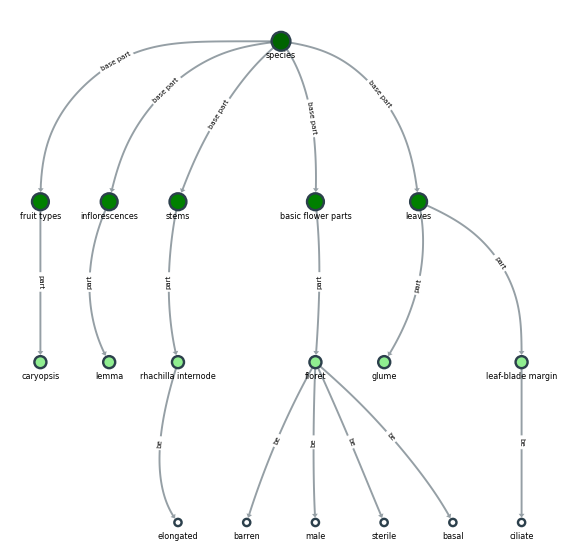

In [67]:
plt.figure(figsize=(10, 10))
Graph(nodes, node_layout='dot', edge_layout='curved', arrows=True,
      node_labels=node_labels, node_label_offset=(0.00, -0.03), node_size=node_size, node_label_fontdict=dict(size=8), node_color=node_color,
      edge_labels=edge_labels, edge_width=0.4, edge_label_fontdict=dict(size=7))

#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')


In [ ]:
node_size

In [ ]:
'''
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(25, 25))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G, k = 0.3*1/np.sqrt(len(G.nodes())))

nx.draw(G,
        #node_color=color_map,
        with_labels=True, 
        node_size=2500, 
        pos=graphviz_layout(G, prog="dot"), )
nx.draw_networkx_edge_labels(G,
                             pos=graphviz_layout(G, prog="dot"), 
                             edge_labels=labels,
                             font_color='red', )
#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

species = list(data.keys())
baseparts = list(glossary.keys())
parts = list(glossary.values())

G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

plt.figure(figsize=(10, 10))
_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
for (subject, object_), edge in _labels.items():
    if subject in species:
        node_size[subject] = 10/3
    elif subject in baseparts:
        node_size[subject] = 8/3
    elif subject in parts:
        node_size[subject] = 4/3
    else:
        node_size[subject] = 4/3
    if object_ in species:
        node_size[object_] = 10/3
    elif object_ in baseparts:
        node_size[object_] = 8/3
    elif object_ in parts:
        node_size[object_] = 4/3
    else:
        node_size[object_] = 4/3
        
labels = {node : node for idx, node in enumerate(G)}
edge_labels = {}
for key in labels.keys():
    if key in baseparts:
        edge_labels[key] = 'basepart'
    else:
        edge_labels[key] = 'other'

Graph(G, node_layout='dot', edge_layout='curved', node_size=node_size, node_labels=labels, node_label_offset=(0.00, -0.04),
      edge_width=0.4, arrows=True,
      node_label_fontdict=dict(size=8),
      edge_label_fontdict=dict(size=6))


#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()
'''